In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter, OrderedDict
import copy 
import pandas as pd
import time
import datetime

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


In [2]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 

In [3]:
data=fulldata[['dataid','local_15min','grid']]
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])
ids=sorteddata['dataid'].unique().tolist()

In [4]:
housing_data = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)

In [5]:
def create_dataset(dataset, look_back=1, look_ahead=None):
	"function for creating dataset for model, X being the known data, and Y being target data"
	if look_ahead is None:
		look_ahead = look_back
	dataX, dataY = [], []
	for i in range(len(dataset)-2*look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		if look_ahead == 0:
			dataY.append(dataset[i + look_back, 0])
		else:
			dataY.append(dataset[(i+look_back):(i+look_back+look_ahead), 0])
		
	return np.array(dataX), np.array(dataY)


In [6]:
def get_avg_day(look_back =96,  house = 0, absolute = False):

    dataframe = housing_data[house]['grid']
    fulldays=len(dataframe)//look_back
    grid_data=dataframe.to_numpy()

    grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, look_back)
    if absolute == True:
        grid_day_matrix = abs(grid_day_matrix)
    #avg house0 grid data 
    avg_house_grid=np.mean(grid_day_matrix, axis=0)
    # print(grid_day_matrix.shape)
    return avg_house_grid


In [7]:
model = load_model('../models/D_0house_model_1_25_adam.h5')
scaler = MinMaxScaler(feature_range=(0, 1))
def get_avg_day_pred(look_back =96,  house = 0, scaler = scaler, model = model):

    dataframe = housing_data[house]['grid']
    dataset = np.matrix(dataframe.values).transpose()
    dataset = dataset.astype('float32')
    dataset = scaler.fit_transform(dataset)

    house0X, house0Y = create_dataset(dataset, look_back)
    house0X = house0X.reshape(house0X.shape[0], house0X.shape[1],1)
    house0Predict = model.predict(house0X)
    house0Predict = scaler.inverse_transform(house0Predict)
    house0Y = scaler.inverse_transform(house0Y)
    train0Score = math.sqrt(mean_squared_error(house0Y, house0Predict))

    pred_house0_matrix=house0Predict[::look_back]
    
    #avg house0 grid data 
    pred_house0_grid=np.mean(pred_house0_matrix, axis=0)
    # print(grid_day_matrix.shape)
    return pred_house0_grid, train0Score

In [8]:
avg_house0_grid = get_avg_day(house= 0)

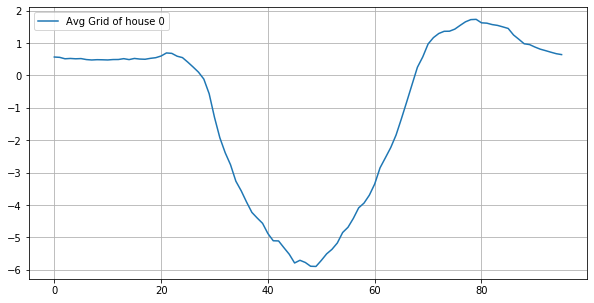

In [9]:
plt.figure(figsize=(10,5))
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
plt.grid(True)
plt.legend()

In [10]:
len(housing_data)

25

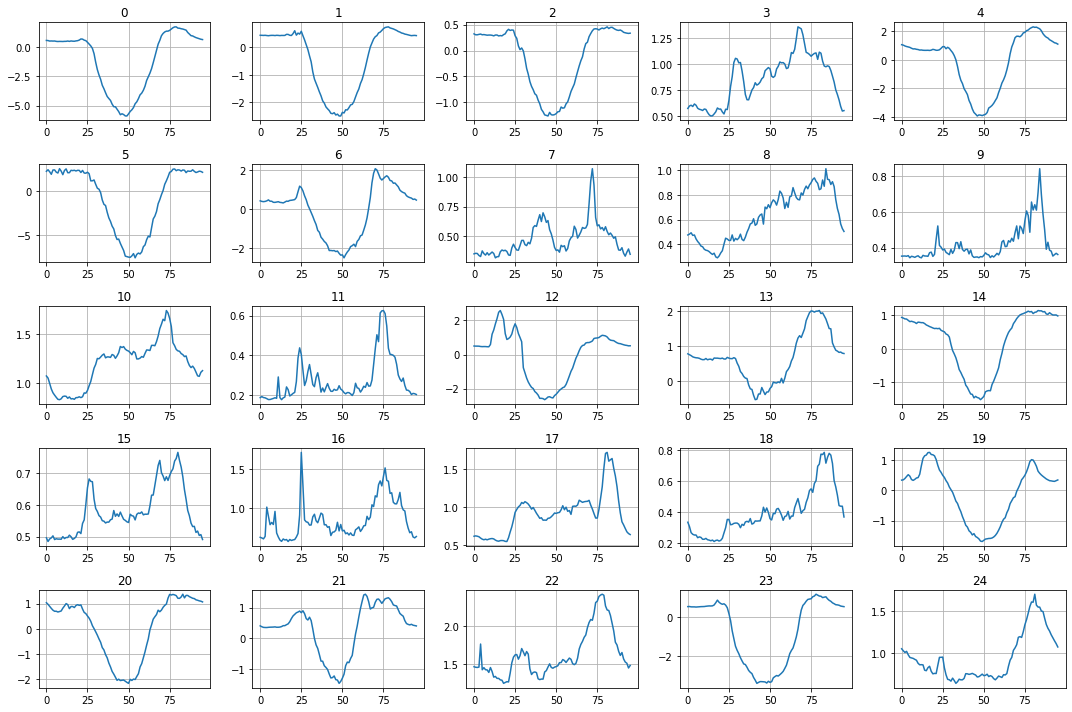

In [11]:
# avg_house_grid_list = []
plt.figure(figsize=(15, 10))
for i in range(len(housing_data)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    plt.plot(get_avg_day(house= i))
    plt.title(f'{i}')
    plt.grid(True)
plt.tight_layout()
# plt.grid(True)
# plt.legend()

# Model Prediction on each house 


In [12]:
pred_house0_grid,_ = get_avg_day_pred(house= 0)

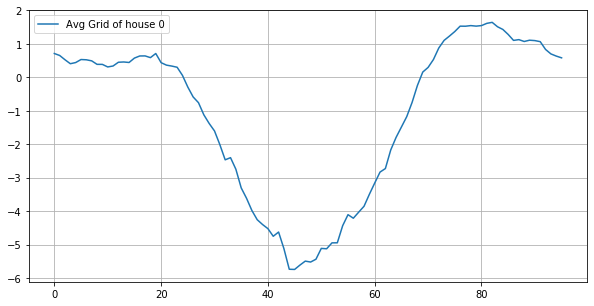

In [13]:
plt.figure(figsize=(10,5))
plt.plot(pred_house0_grid, label= 'Avg Grid of house 0' )
plt.grid(True)
plt.legend()

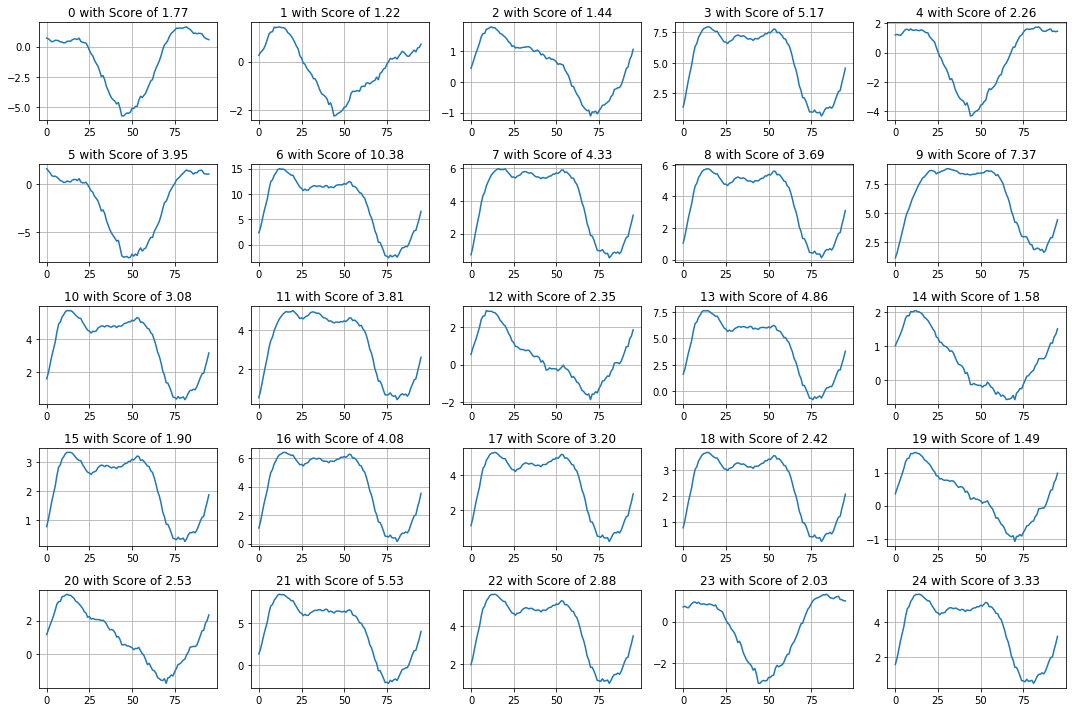

In [14]:
# predicton output with RMS score of total data
plt.figure(figsize=(15, 10))
for i in range(len(housing_data)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    pred_house_grid,Score = get_avg_day_pred(house= i)
    plt.plot(pred_house_grid)
    plt.title(f'{i} with Score of {Score:.2f}')
    plt.grid(True)
plt.tight_layout()
# plt.grid(True)
# plt.legend()

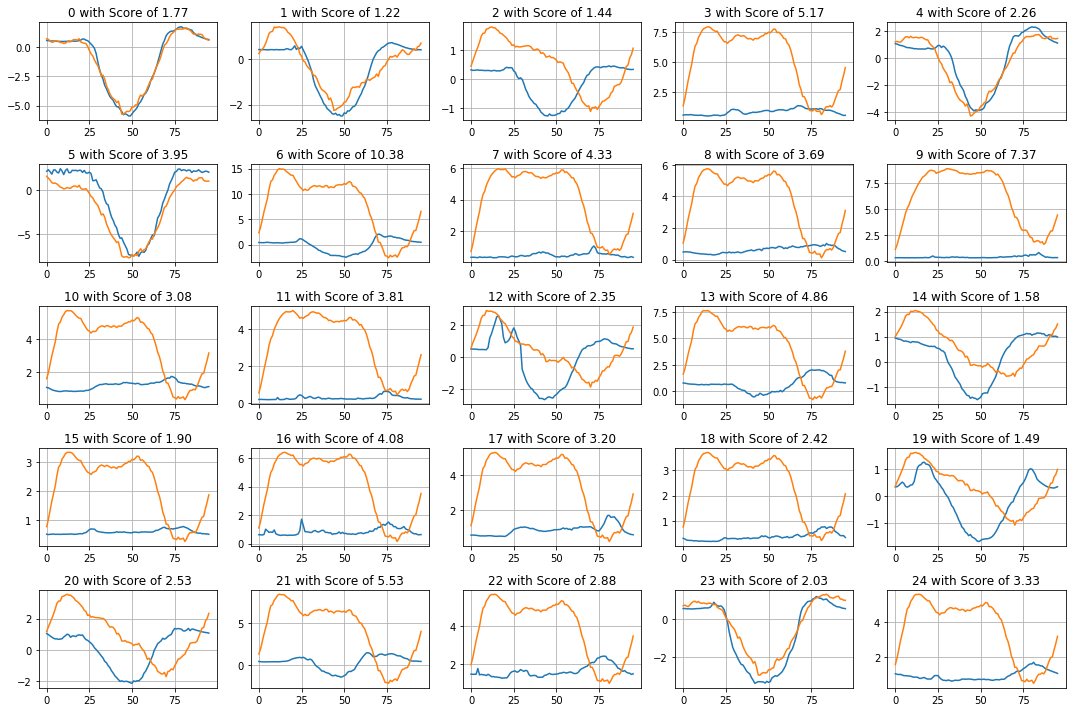

In [15]:
#compare true (blue) with pred (orange)

plt.figure(figsize=(15, 10))
for i in range(len(housing_data)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    pred_house_grid,Score = get_avg_day_pred(house= i)
    plt.plot(get_avg_day(house= i))
    plt.plot(pred_house_grid)
    plt.title(f'{i} with Score of {Score:.2f}')
    plt.grid(True)
plt.tight_layout()
# plt.grid(True)
# plt.legend()

## Abs Average house


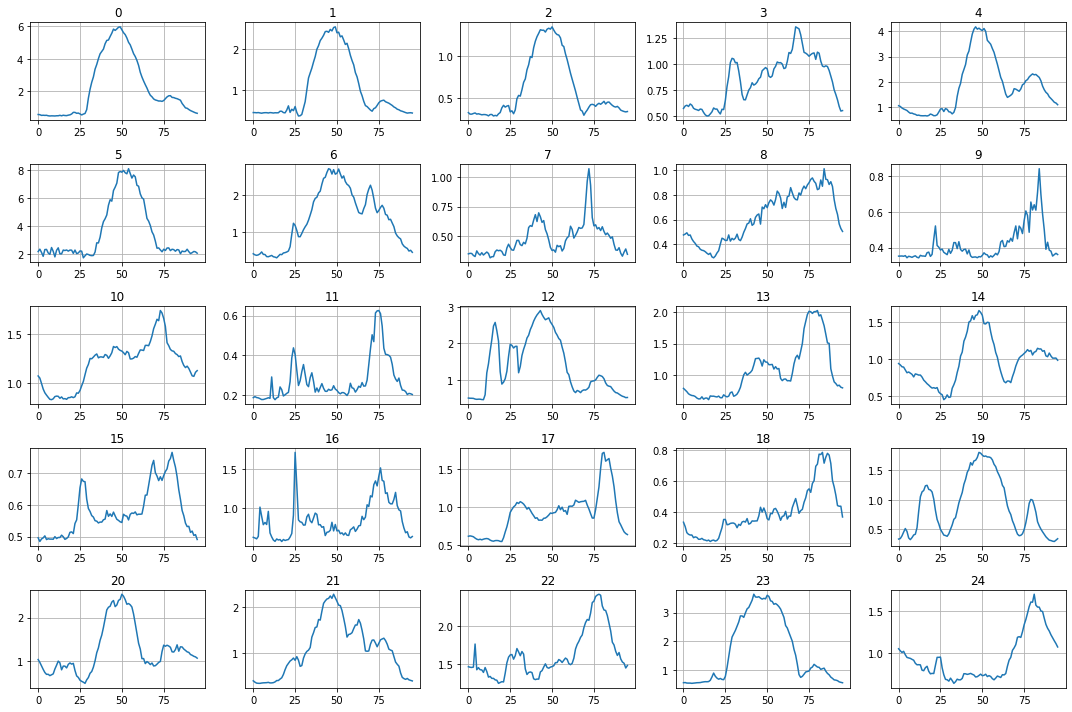

In [16]:
# avg_house_grid_list = []
plt.figure(figsize=(15, 10))
for i in range(len(housing_data)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    plt.plot(get_avg_day(house= i, absolute=True))
    plt.title(f'{i}')
    plt.grid(True)
plt.tight_layout()
# plt.grid(True)
# plt.legend()

# Percent Error for Each House

In [23]:
def get_day_withavg_pred_error(look_back=96,house=0,scaler=scaler,model=model):
    #get data
    dataframe = housing_data[house]['grid']
    dataset = np.matrix(dataframe.values).transpose()
    dataset = dataset.astype('float32')
    dataset = scaler.fit_transform(dataset)
    #get pred 
    house0X, house0Y = create_dataset(dataset, look_back)
    house0X = house0X.reshape(house0X.shape[0], house0X.shape[1],1)
    house0Predict = model.predict(house0X)
    house0Predict = scaler.inverse_transform(house0Predict)
    house0Y = scaler.inverse_transform(house0Y)
    #get full error of each point
    fullpredict =house0Predict[::look_back].reshape(182*96)
    fulldatap1= house0Y[::look_back].reshape(182*96)
    fullerror = abs(fulldatap1 - fullpredict)
    #get avg 15min output per day  
    fullerror_matrix = fullerror.reshape(182,96)
    averageerror = np.mean(fullerror_matrix, axis=0)
    fulldatap1_matrix = fulldatap1.reshape(182,96)
    avg_house_grid = np.mean(abs(fulldatap1_matrix), axis = 0)
    #other metrics
    min_avg_error = min(fullerror)
    max_avg_error = max(fullerror)
    avg_error = np.mean(averageerror)
    errorstd_avg = np.std(fullerror)
    #
    error_percentage = errorstd_avg/avg_house_grid

    return error_percentage, min_avg_error, max_avg_error, avg_error, errorstd_avg, averageerror

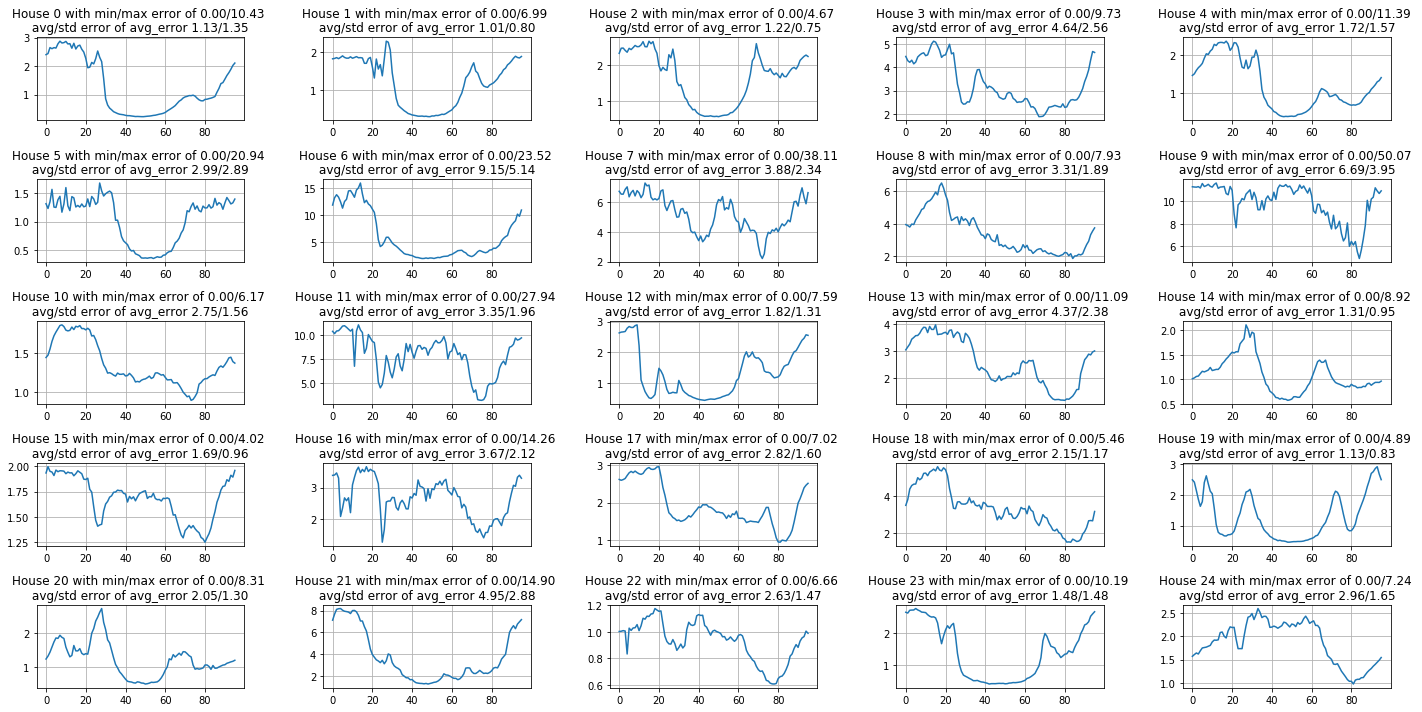

In [24]:
#compare true (blue) with pred (orange)

plt.figure(figsize=(20, 10))
for i in range(len(housing_data)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    error_percentage,min_avg_error, max_avg_error, avg_error, errorstd_avg, averageerror= get_day_withavg_pred_error(house= i)
    # plt.plot(averageerror)
    plt.plot(error_percentage)
    plt.title(f'House {i} with min/max error of {min_avg_error:.2f}/{max_avg_error:.2f} \n avg/std error of avg_error {avg_error:.2f}/{errorstd_avg:.2f} ')
    # print(f'House {i} with min/max error of {min_avg_error:.2f}/{max_avg_error:.2f}, avg/std error of avg_error {avg_error:.2f}/{errorstd_avg:.2f} ')
    plt.grid(True)
plt.tight_layout()
# plt.grid(True)
# plt.legend()

In [19]:
# look_back = 96
# dataframe = housing_data[0]['grid']
# dataset = np.matrix(dataframe.values).transpose()
# dataset = dataset.astype('float32')
# dataset = scaler.fit_transform(dataset)

# house0X, house0Y = create_dataset(dataset, look_back)
# house0X = house0X.reshape(house0X.shape[0], house0X.shape[1],1)
# house0Predict = model.predict(house0X)
# house0Predict = scaler.inverse_transform(house0Predict)
# house0Y = scaler.inverse_transform(house0Y)

# fullpredict =house0Predict[::look_back].reshape(182*96)
# comparetrue= house0Y[::look_back].reshape(182*96)
# fullerror = abs(comparetrue - fullpredict)

# fullerror_matrix = fullerror.reshape(182,96)
# averageerror = np.mean(fullerror_matrix, axis=0)

In [20]:
# averageerror